#### A circuit model of an LC bandpass filter
Originally implemnted in PLECS, then compared with Julia ACME.jl package.
This model determines the current drawn from the voltage source for a Gaussian
voltage pulse aplied as an input to the filter.

The goal is to use automatic differentiation to calculate $\partial i/\partial v$ which is needed
for the nonlinear Finite Element Method.

In [1]:
using ACME

cir = @circuit begin
    v  = voltagesource(), [-] == gnd
    i  = currentprobe(),  [-] == gnd
    r1 = resistor(5.00),  [1] == v[+]
    c1 = capacitor(1e-9), [1] == r1[2], [2] == i[+]
    r2 = resistor(0.05),  [1] == v[+]
    l1 = inductor(10e-9), [1] == r2[2], [2] == i[+]
end
nothing

In [2]:
Δt = 0.01e-9
model = DiscreteModel(cir, Δt)
nothing

In [3]:
t = range(0.0, 1.5e-6, step=Δt)
u = [exp(-(ti - 1e-7)^2 / 3e-16) for ti in t]
y = run!(model, [ui for c in 1:1, ui in u])

1×150001 Matrix{Float64}:
 6.6865e-16  6.75127e-16  6.81651e-16  …  0.00280499  0.00280485  0.00280471

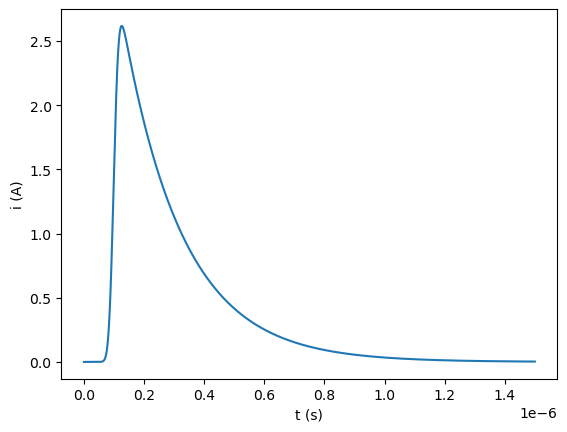

In [4]:
using PyPlot
plot(t, y[:])
xlabel("t (s)")
ylabel("i (A)")
nothing

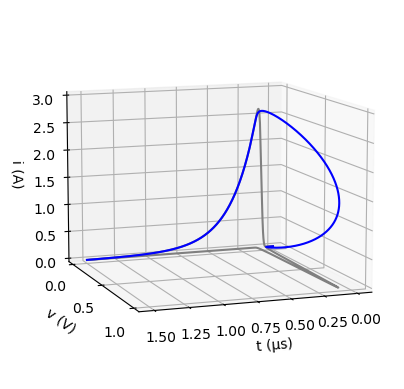

In [5]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(1e6t, u[:], 0.0t, "gray")
ax.plot3D(1e6t, 0.0t, y[:], "gray")
ax.plot3D(1e6t, u[:], y[:], "blue")
yticks(0:0.5:1)
zticks(0:0.5:3)
xlabel("t (μs)")
ylabel("v (V)")
zlabel("i (A)")
ax.view_init(10, 70)

#### Custom and naive dual number implementation
We are defining a basic set of operations on dual numbers which allow for easy automatic differentiation.

In [6]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

#### Automatic Differentiation of ACME.jl model
Let's try to differentiate the circuit using ACME.jl.

In [7]:
Δt = 0.01e-9
model = DiscreteModel(cir, Δt)

t = range(0.0, 0.5e-6, step=Δt)
u = [exp(-(ti - 1e-7)^2 / 3e-16) for ti in t]
y = run!(model, [(ui + ε) for c in 1:1, ui in u])

LoadError: MethodError: no method matching run!(::DiscreteModel{Tuple{}}, ::Matrix{Dual{Float64}})
[0mClosest candidates are:
[0m  run!(::DiscreteModel, [91m::AbstractMatrix{Float64}[39m; showprogress) at /Users/bach/.julia/packages/ACME/UHz8S/src/ACME.jl:542

#### Finite-Difference of ACME.jl model

In [8]:
import Base

Δt = 0.01e-9
model = DiscreteModel(cir, Δt)
copied = DiscreteModel(cir, Δt)

Base.copy!(dst::T, src::T) where T = for k ∈ fieldnames(T)
  if typeof(getfield(src, k)) <: Array
    copy!(getfield(dst, k), getfield(src, k))
  end
end

t = range(0.0, 1.5e-6, step=Δt)
u = similar(t)
y = similar(t)
z = similar(t)
dy = similar(t)

for i in 1:length(t)
    copy!(copied, model)
    ui = exp(-(t[i] - 1e-7)^2 / 3e-16)
    uj = ui - 1e-4
    
    yi = run!(model, ui * ones(1,1))[1]
    yj = run!(copied, uj * ones(1,1))[1]
    dydu = (yj - yi) / (uj - ui)
    
    u[i]  = ui
    y[i]  = yi
    z[i]  = yj
    dy[i] = dydu
end

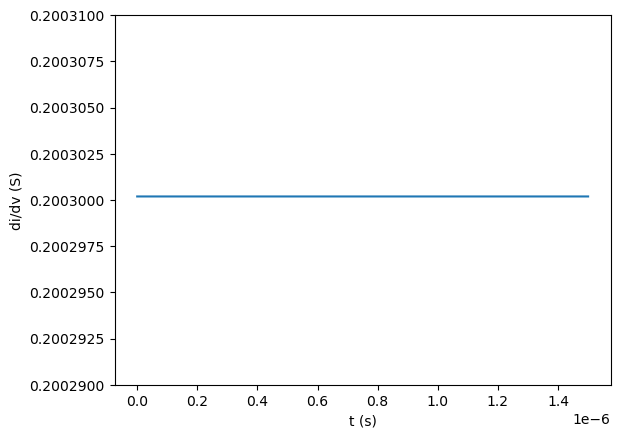

In [9]:
plot(t, dy)
xlabel("t (s)")
ylabel("di/dv (S)")
ylim([2.0029e-1, 2.0031e-1]);